# The Home Depot Decor Case

Getting Started |  **Data Exploration**  |  Preprocessing  |  Model Tuning  |  Final Model

In [1]:
__author__ = 'Jaime Garvey'
__email__ = 'jaimemgarvey@gmail.com'

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from collections import Counter

from sklearn.feature_extraction.text import CountVectorizer

pd.set_option('display.max_colwidth', -1)

**Import Helper Function**

In [3]:
# adding the modules directory to path
import sys
sys.path.insert(0, '../modules')

# reading in functions
from helpers import read_in_dataset,get_num_of_levels, flatten_categories

## Read in Data

In [4]:
# Read in product related data
verbose_opt = False
catalog = read_in_dataset('Decor_catalog.csv', verbose=verbose_opt)
prod_desc = read_in_dataset('Product_name_description.csv', verbose=verbose_opt)
prod_engagement = read_in_dataset('Product_engagement.csv', verbose=verbose_opt)

# Read in search related data
navigations = read_in_dataset('Visual_navigations.csv', verbose=verbose_opt)
search_imp = read_in_dataset('Search_impression.csv', verbose=verbose_opt)

## Explore Raw Data
* View 
* Shape
* Describe

**Datasets:**
* Product Datasets: catalog, prod_desc, prod_engagement
* Search Datasets navigations, search_imp 

## Product

### Decor Catalog

In [40]:
catalog.head()

,SKU_ID,Category
0,302087889,Lighting>Sconces
1,301688935,Lighting>Sconces
2,206788920,Lighting>Sconces
3,302087892,Lighting>Sconces
4,302087891,Lighting>Sconces


In [42]:
catalog['Category'] = catalog['Category'].str.split('>')

In [80]:
catalog.set_index('SKU_ID', inplace=True)

In [6]:
# Number of Level for product categories
get_num_of_levels(catalog['Category'], verbose=True);

Max Number of Category Levels: 6


#### Check for Duplicates

In [7]:
#check if every SKU is unique
len(catalog) == catalog['SKU_ID'].nunique()

False

In [8]:
# View product that belongs to more than one path
multiple_paths = catalog[catalog.duplicated(subset='SKU_ID', keep=False)].sort_values('SKU_ID')
one_path = catalog[catalog.groupby('SKU_ID')['Category'].transform('count') ==1]

assert len(catalog) == len(multiple_paths) +len(one_path)

* There is a max depth of 6 levels of product categories
* Know some products belong to multiple categories (we'll have to deal with this later)

### Product Engagement

In [9]:
prod_engagement.head()

,Search_term,SKU_ID,Product_views
0,accent table,301116997,82
1,accent table,306775214,65
2,accent table,301285388,64
3,accent table,301285396,61
4,accent table,302987915,51


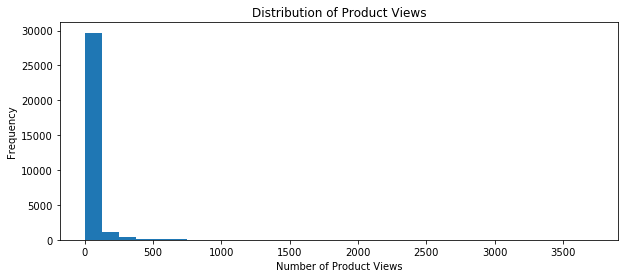

In [34]:
#view distribution of views
plt.figure(figsize=(10,4))
plt.hist(prod_engagement['Product_views'], bins=30)
plt.title("Distribution of Product Views")
plt.xlabel("Number of Product Views")
plt.ylabel("Frequency");

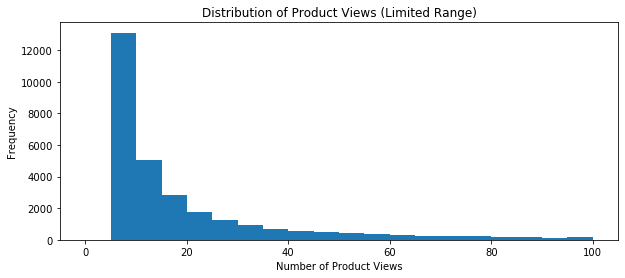

In [35]:
#view distribution of views (limited range)
plt.figure(figsize=(10,4))
plt.hist(prod_engagement['Product_views'], bins=20,range=(0,100))
plt.title("Distribution of Product Views (Limited Range)")
plt.xlabel("Number of Product Views")
plt.ylabel("Frequency");

In [36]:
# Average Number of Products per Search Term 
prod_engagement.groupby('Search_term')['SKU_ID'].count().mean()

93.19822485207101

* Views (implicit rating for products)
* The majority of product have under 100 views, which some exceeding 3,000. We will have to be careful with using this data for recommendation to prevent our model form favoring the few products with a larger amount of views. 

### Product Descriptions

In [10]:
prod_desc.head(2)

,SKU_ID,Product_name,Description,Department
0,202524817,8 in. x 4 in. x 16 in. Concrete Solid Block,This 8 in. x 4 in. x 16 in. Solid Concrete Block makes a great choice for the construction of Piers in Pier and Beam construction or mobile home installation. It is also a great block to use as a spacer block between other units to obtain an optimal height.,Non-Decor
1,301169855,Hummingbird Stencil,"This easy-to-use Hummingbird Stencil from Stencil1 is perfect for walls, home decor, clothing and more. Each stencil is cut high quality in order to provide a long lasting design. The possibilities of what you can create with a Stencil1 stencil are endless.",Non-Decor


In [11]:
prod_desc['Department'].unique()

array(['Non-Decor', 'Core Decor', 'Growth Decor'], dtype=object)

In [12]:
# Merge Product Description and Catalog dataframes
prod_desc_cat = pd.merge(prod_desc,catalog, on='SKU_ID')

# Flatten nested category column into separate columns 
prod_desc_cat = flatten_categories(prod_desc_cat['Category'], df=prod_desc_cat, drop_col='Category', sep='>')
prod_desc_cat.head()

,SKU_ID,Product_name,Description,Department,L1,L2,L3,L4,L5,L6
0,202524817,8 in. x 4 in. x 16 in. Concrete Solid Block,This 8 in. x 4 in. x 16 in. Solid Concrete Block makes a great choice for the construction of Piers in Pier and Beam construction or mobile home installation. It is also a great block to use as a spacer block between other units to obtain an optimal height.,Non-Decor,Building Materials,"Concrete, Cement & Masonry",Concrete Blocks & Bricks,Cinder Blocks,NaN,NaN
1,301169855,Hummingbird Stencil,"This easy-to-use Hummingbird Stencil from Stencil1 is perfect for walls, home decor, clothing and more. Each stencil is cut high quality in order to provide a long lasting design. The possibilities of what you can create with a Stencil1 stencil are endless.",Non-Decor,Home Decor,Wall Decor,Wall Stencils,NaN,NaN,NaN
2,301169855,Hummingbird Stencil,"This easy-to-use Hummingbird Stencil from Stencil1 is perfect for walls, home decor, clothing and more. Each stencil is cut high quality in order to provide a long lasting design. The possibilities of what you can create with a Stencil1 stencil are endless.",Non-Decor,Paint,Craft & Art Supplies,Stencils,NaN,NaN,NaN
3,207096840,24 in. x 24 in. x 2 in Acrylic clear/White Dry erase board,"The BOOM BOOM board is a high end dry erase board made from acrylic. This product is available in three colors; clear (with white backing), white and black. This can be placed in schools, meeting rooms, cafeterias and anywhere else where dry erase is needed.",Non-Decor,Building Materials,Glass & Plastic Sheets,Acrylic Sheets,NaN,NaN,NaN
4,207096521,48 in. x 96 in. x 2 in Clear/White Boom Dry erase board,"The BOOM BOOM board is a high end dry erase board made from acrylic. This product is available in three colors; clear (with white backing), white and black. This can be placed in schools, meeting rooms, cafeterias and anywhere else where dry erase is needed.",Non-Decor,Building Materials,Glass & Plastic Sheets,Acrylic Sheets,NaN,NaN,NaN


In [13]:
prod_desc_cat[prod_desc_cat['L1']== 'Furniture']['L2'].unique()

array(['Living Room Furniture',
       'Furniture Accessories & Replacement Parts', 'Entryway Furniture',
       'Kids & Baby Furniture', 'Bedroom Furniture',
       'Folding Tables & Chairs', 'Kitchen & Dining Room Furniture',
       'Home Office Furniture'], dtype=object)

In [14]:
prod_desc_cat.groupby('L1')

In [ ]:
#Save to pickle
#prod_desc_cat.to_pickle('../data/processed/prod_desc_cat.pkl')

Text(0.5, 1.0, 'Number of Categories by Level')

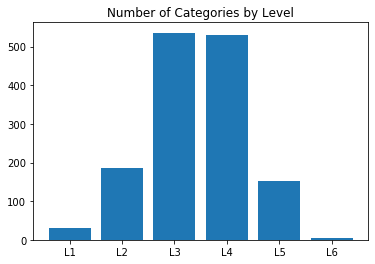

In [18]:
#View all Level 1 Categories
plt.bar(x=prod_desc_cat.columns[-6:], height=prod_desc_cat.iloc[:,-6:].nunique())
plt.title("Number of Categories by Level")

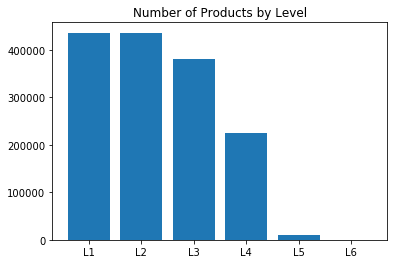

In [16]:
plt.bar(x=prod_desc_cat.columns[-6:], height=prod_desc_cat.iloc[:,-6:].count())
plt.title("Number of Products by Level");

* Majority of product go to 3 levels deep in taxonomy

#### Top Words in Product Names

In [ ]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_words(df['Product_name'], 20)
df1 = pd.DataFrame(common_words, columns = ['Product_name' , 'count'])
pd.DataFrame(df1.groupby('Product_name').sum()['count'].sort_values()).plot(kind='barh', y='count', title="Top 20 words in Product Names");

In [ ]:
# Define List of Stop Words
new_stop_words = ['in', 'sq','ft', 'yd', 'cm', 'mm','gal','lb' ,'lbs','qt','oz', 'h', 'w', 'ii', 'x']
stop_words = set(stopwords.words('english') + new_stop_words)

In [ ]:
# View Top Words without Stop Words
def get_top_n_words(corpus, n=None, stop_words=stop_words):
    vec = CountVectorizer(stop_words=stop_words, token_pattern='([a-zA-z]+)').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words_no_stopwords = get_top_n_words(df['Product_name'], 20)
df2 = pd.DataFrame(common_words_no_stopwords, columns = ['Product_name' , 'count'])
pd.DataFrame(df2.groupby('Product_name').sum()['count'].sort_values()).plot(kind='barh', y='count', title="Top 20 words in Product Names (w/o Stopwords)");

## Search

### Navigation

In [15]:
navigations.head(2)

,Search_term,Recommended_category,Display_name
0,accent table,Furniture>Entryway Furniture>Entryway Tables,Entryway Tables
1,accent table,Furniture>Living Room Furniture>Accent Tables>End Tables,End Tables


In [16]:
# Number of unique search terms
print("Number of Unique Search Terms: {}".format(navigations['Search_term'].nunique()))
print("Number of Unique Display Names: {}".format(navigations['Display_name'].nunique()))

Number of Unique Search Terms: 354
Number of Unique Display Names: 233


In [17]:
# Max Number of Levels
get_num_of_levels(navigations['Recommended_category'], verbose=True);

Max Number of Category Levels: 5


In [18]:
# Flatten nested category column into separate columns 
search_prod_levels = flatten_categories(navigations['Recommended_category'], df=navigations, drop_col='Recommended_category', sep='>')
search_prod_levels.head()

,Search_term,Display_name,L1,L2,L3,L4,L5
0,accent table,Entryway Tables,Furniture,Entryway Furniture,Entryway Tables,NaN,NaN
1,accent table,End Tables,Furniture,Living Room Furniture,Accent Tables,End Tables,NaN
2,accent table,Coffee Tables,Furniture,Living Room Furniture,Accent Tables,Coffee Tables,NaN
3,accent table,Console Tables,Furniture,Living Room Furniture,Accent Tables,Console Tables,NaN
4,accent table,Indoor Plant Stands,Furniture,Living Room Furniture,Accent Tables,Indoor Plant Stands,NaN


In [19]:
search_prod_levels[search_prod_levels['L1'] == 'Furniture']['L2'].nunique()

8

In [57]:
#Save to pickle
search_prod_levels.to_pickle('../data/processed/search_prod_levels.pkl')

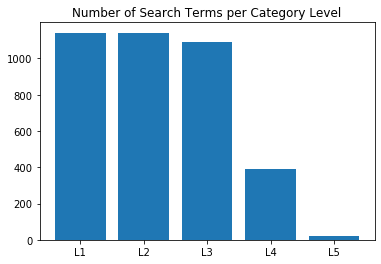

In [39]:
# View number of search term per level
plt.bar(x=['L1','L2','L3','L4','L5'], height=search_prod_levels[['L1','L2','L3','L4','L5']].count())
plt.title("Number of Search Terms per Category Level");

#### Display Name

In [20]:
# View number of Display Names per Search Term
navigations.groupby('Search_term')['Display_name'].count().sort_values(ascending=False).head();

In [21]:
# View Display Names by Search Term 
# Example of desired input - outputs
term_display_names = pd.DataFrame(navigations.groupby('Search_term')['Display_name'].apply(list))
term_display_names.head()

,Display_name
Search_term,
accent table,"[Entryway Tables, End Tables, Coffee Tables, Console Tables, Indoor Plant Stands]"
accent tables,"[Entryway Tables, End Tables, Coffee Tables, Console Tables, Indoor Plant Stands]"
adhesive backsplash,"[Metal Backsplash, Tile Backsplash]"
adhesive tile backsplash,"[Metal Backsplash, Tile Backsplash]"
arm chair,"[Folding Chairs, Office Chairs, Accent Chairs, Outdoor Dining Chairs]"


##### IDEA: Could encode display names and look at similarity of search terms
navigations.pivot_table(index='Search_term', columns='Display_name', aggfunc='count').head()

### Search Impressions

In [26]:
search_imp.head()

,Search_term,Impression
0,coffee,203054703;207061099;305561354;305561469;301692317;206090043;206090041;300742646;204077166;206090050;305365754;206090042;305365870;302776630;206090598;204077145;305848381;206735001;305974710;206090049;207061098;203299655;206090048;303917139
1,bag chair,305573411;305608772;301092388;301092383;301092391;305676166;305676517;305676196;305676124;305676969;305676104;207061513;207061509;207061519;206267150;301092396;303324211;300168381;207061486;204624719;305573360;302643392;207061500;207061517
2,kitchen wall tile,205140711;302603437;205762409;204923728;204337886;204695051;204065143;204289147;204170143;300942624;205858982;206638691;203213521;300947962;302570935;206279726;205626148;206635972;300046421;205889117;203447805;205140722;203029952;205960149
3,mirror tile,305696621;304142073;304142126;304142039;303058463;304187832;303383559;305696699;100656412;304188432;304185242;303382986;206822976;303115245;206822972;206822559;206553088;304352832;304188444;303383001;304189009;206553089;304188317;304184997
4,entryway,203532713;203532652;300750153;302042988;302042995;302042994;206639873;203532749;300750157;206639875;204749403;204123232;203532743;303569609;304302934;303576547;304257392;303579718;204749370;303582863;204749400;303577515;303576183;304302931


In [38]:
search_imp['Search_term'].unique();

In [27]:
#Split impressions into string with space for count vectorizer 
# (e.g. 203054703;207061099 t0 203054703 207061099)
search_imp['Impression']= search_imp['Impression'].str.replace(';',' ')

In [28]:
#Average amount of words per search term
search_imp['Search_term'].str.split().apply(len).mean()

2.1129943502824857

# Test

In [171]:
# List of products accent table
at_prods = search_imp[search_imp['Search_term'] =='end table']['Impression'].str.split()
#a = at_prods.to_list()
#at_prods= a[0]

# labels
def get_labels(prod_lst=at_prods):
    
    labels = []
    for prod in prod_lst:
        lst = catalog.loc[int(prod)]
        
        if len(lst)>1:
            lsts = catalog.loc[int(prod)]['Category'].to_list()
            for l in lsts:
                labels.extend(l)
        else:
            labels.extend(lst['Category'])
        
    d = Counter(labels)
    
    return d 
    

In [172]:
get_labels()

Counter()

In [114]:
labels = []
for prod in at_prods:
    labels.extend(catalog.loc[int(prod)]['Category'])

In [165]:
len(catalog.loc[int(at_prods[0])])

1

In [106]:
labels.append(catalog.loc[int(at_prods[0])])

In [111]:
catalog.loc[int(at_prods[0])]['Category']

['Furniture', 'Living Room Furniture', 'Accent Tables', 'End Tables']

In [85]:
catalog.head(1)

,Category
SKU_ID,
302087889,"[Lighting, Sconces]"


In [89]:
catalog.loc[302087889]

Category    [Lighting, Sconces]
Name: 302087889, dtype: object

In [174]:
search_imp[search_imp['Search_term'] =='end table']

,Search_term,Impression


In [39]:
prod_desc_cat

,SKU_ID,Product_name,Description,Department,L1,L2,L3,L4,L5,L6
0,202524817,8 in. x 4 in. x 16 in. Concrete Solid Block,This 8 in. x 4 in. x 16 in. Solid Concrete Block makes a great choice for the construction of Piers in Pier and Beam construction or mobile home installation. It is also a great block to use as a spacer block between other units to obtain an optimal height.,Non-Decor,Building Materials,"Concrete, Cement & Masonry",Concrete Blocks & Bricks,Cinder Blocks,NaN,NaN
1,301169855,Hummingbird Stencil,"This easy-to-use Hummingbird Stencil from Stencil1 is perfect for walls, home decor, clothing and more. Each stencil is cut high quality in order to provide a long lasting design. The possibilities of what you can create with a Stencil1 stencil are endless.",Non-Decor,Home Decor,Wall Decor,Wall Stencils,NaN,NaN,NaN
2,301169855,Hummingbird Stencil,"This easy-to-use Hummingbird Stencil from Stencil1 is perfect for walls, home decor, clothing and more. Each stencil is cut high quality in order to provide a long lasting design. The possibilities of what you can create with a Stencil1 stencil are endless.",Non-Decor,Paint,Craft & Art Supplies,Stencils,NaN,NaN,NaN
3,207096840,24 in. x 24 in. x 2 in Acrylic clear/White Dry erase board,"The BOOM BOOM board is a high end dry erase board made from acrylic. This product is available in three colors; clear (with white backing), white and black. This can be placed in schools, meeting rooms, cafeterias and anywhere else where dry erase is needed.",Non-Decor,Building Materials,Glass & Plastic Sheets,Acrylic Sheets,NaN,NaN,NaN
4,207096521,48 in. x 96 in. x 2 in Clear/White Boom Dry erase board,"The BOOM BOOM board is a high end dry erase board made from acrylic. This product is available in three colors; clear (with white backing), white and black. This can be placed in schools, meeting rooms, cafeterias and anywhere else where dry erase is needed.",Non-Decor,Building Materials,Glass & Plastic Sheets,Acrylic Sheets,NaN,NaN,NaN


**Sparse Matrix for Search Terms and SKU**

In [24]:
from sklearn.feature_extraction.text import CountVectorizer 

In [25]:
vectorizer = CountVectorizer()
term_sku = vectorizer.fit_transform(search_imp['Impression'])
term_sku.shape

(354, 4764)

In [26]:
term_sku_df = pd.DataFrame(term_sku.toarray(), index=search_imp['Search_term'], columns=vectorizer.get_feature_names())
term_sku_df.head()

,100012014,100022800,100023109,100023973,100036137,100044505,100048075,100051570,100061089,100074869,...,307717049,307717219,307717221,307727052,307833295,307920434,307939445,307939707,307940057,307940314
Search_term,,,,,,,,,,,,,,,,,,,,,
coffee,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
bag chair,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
kitchen wall tile,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
mirror tile,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
entryway,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
